<a href="https://colab.research.google.com/github/MichailLepin/Fake-News-Classifier/blob/main/notebooks/cnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model Training for Fake News Classification

This notebook contains code for training a CNN model for fake news classification in Google Colab.

## Notebook Structure

1. **Install Dependencies** - Install required libraries
2. **Imports** - Import all necessary modules
3. **Load and Process Data** - Load ISOT/Kaggle dataset and preprocessing
4. **Build Vocabulary and Tokenization** - Build vocabulary and convert text to sequences
5. **Load GloVe Embeddings** - Load pre-trained word embeddings
6. **PyTorch Dataset** - Create datasets for training
7. **CNN Model** - Define CNN architecture
8. **Training Functions** - Functions for training and evaluating the model
9. **Training** - Model training process
10. **Test Set Evaluation** - Final model evaluation



## Install Dependencies

Install all required libraries for PyTorch, data processing, and visualization.


In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn pandas numpy matplotlib seaborn tqdm
!pip install kagglehub



Looking in indexes: https://download.pytorch.org/whl/cu118


## Imports

Import all necessary libraries and modules for data processing, models, and metrics.


In [7]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Проверка GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')



Using device: cpu


## Load and Process Data

Load ISOT/Kaggle dataset from Kaggle and perform preprocessing:
- Load Fake.csv and True.csv via kagglehub
- Text cleaning (lowercase, URL removal, whitespace normalization)
- Create binary labels
- Stratified train/validation/test split (64%/16%/20%)


In [8]:
import re
import kagglehub

# Download dataset via kagglehub (no API keys required)
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

# Load data
fake_df = pd.read_csv(f"{path}/Fake.csv")
true_df = pd.read_csv(f"{path}/True.csv")

print(f"✓ Fake news loaded: {fake_df.shape}")
print(f"✓ True news loaded: {true_df.shape}")

# Text cleaning function (from analyze_and_integrate.py script)
def clean_text(text):
    """Clean text: lowercase, remove URLs, normalize whitespace"""
    if pd.isna(text):
        return ""
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Identify text column
text_col = None
for col in fake_df.columns:
    if fake_df[col].dtype == 'object' and col.lower() in ['text', 'title', 'article']:
        text_col = col
        break
if text_col is None:
    text_col = fake_df.select_dtypes(include=['object']).columns[0]

print(f"\nUsing column: '{text_col}'")

# Add labels
fake_df['label'] = 'fake'
true_df['label'] = 'real'

# Combine data
combined_data = pd.concat([fake_df, true_df], ignore_index=True)

# Clean text
print("\nCleaning text...")
combined_data['text_cleaned'] = combined_data[text_col].apply(clean_text)

# Create binary labels
combined_data['label_binary'] = combined_data['label'].map({'fake': 1, 'real': 0})

# Remove empty texts
combined_data = combined_data[
    combined_data['text_cleaned'].notna() &
    (combined_data['text_cleaned'].str.len() > 0)
]

print(f"\nCombined dataset: {combined_data.shape}")
print(f"Label distribution: {combined_data['label'].value_counts().to_dict()}")

# Split into train/val/test with stratification
X = combined_data['text_cleaned'].values
y = combined_data['label_binary'].values

# First split: train+val (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train (64%) and val (16%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"\nData split:")
print(f"  Train: {len(X_train):,} ({len(X_train)/len(combined_data)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} ({len(X_val)/len(combined_data)*100:.1f}%)")
print(f"  Test: {len(X_test):,} ({len(X_test)/len(combined_data)*100:.1f}%)")


Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
✓ Fake news loaded: (23481, 4)
✓ True news loaded: (21417, 4)

Using column: 'title'

Cleaning text...

Combined dataset: (44889, 7)
Label distribution: {'fake': 23472, 'real': 21417}

Data split:
  Train: 28,728 (64.0%)
  Validation: 7,183 (16.0%)
  Test: 8,978 (20.0%)


## Build Vocabulary and Tokenization

Build vocabulary from training data and functions to convert text to index sequences.


In [9]:
def build_vocab(texts, min_freq=2):
    """Build vocabulary from texts"""
    word_counts = Counter()
    for text in texts:
        words = str(text).lower().split()
        word_counts.update(words)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2

    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1

    return vocab

def text_to_sequence(text, vocab, max_len=256):
    """Convert text to sequence of indices"""
    words = str(text).lower().split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words[:max_len]]

    if len(sequence) < max_len:
        sequence.extend([vocab['<PAD>']] * (max_len - len(sequence)))

    return sequence[:max_len]

# Build vocabulary
print("\nBuilding vocabulary...")
vocab = build_vocab(X_train, min_freq=2)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Model parameters
MAX_LEN = 256
EMBEDDING_DIM = 100



Building vocabulary...
Vocabulary size: 18321


## Load GloVe Embeddings

Load pre-trained GloVe embeddings (GloVe 6B.100d) to initialize the model's embedding layer.


In [5]:
def load_glove_embeddings(glove_path, vocab, embedding_dim=100):
    """Load pre-trained GloVe embeddings"""
    print(f"Loading GloVe embeddings from {glove_path}...")

    if not os.path.exists(glove_path):
        print("Downloading GloVe 6B.100d...")
        !wget -q http://nlp.stanford.edu/data/glove.6B.zip
        !unzip -q glove.6B.zip

    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    found = 0

    for word, idx in vocab.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
            found += 1
        else:
            # Random initialization for unknown words
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    print(f"Found embeddings for {found}/{vocab_size} words ({found/vocab_size*100:.2f}%)")
    return embedding_matrix

# Load GloVe embeddings
GLOVE_PATH = 'glove.6B.100d.txt'
try:
    embedding_matrix = load_glove_embeddings(GLOVE_PATH, vocab, EMBEDDING_DIM)
    use_pretrained = True
except Exception as e:
    print(f"⚠ Failed to load GloVe: {e}")
    print("Using random initialization")
    embedding_matrix = None
    use_pretrained = False


Loading GloVe embeddings from glove.6B.100d.txt...


Loading GloVe: 400000it [00:08, 48773.17it/s]


Found embeddings for 11316/18321 words (61.77%)


## PyTorch Dataset

Create Dataset and DataLoader classes for efficient data loading during training.


In [10]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=256):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        sequence = text_to_sequence(text, self.vocab, self.max_len)
        return torch.LongTensor(sequence), torch.LongTensor([label])

train_dataset = NewsDataset(X_train, y_train, vocab, MAX_LEN)
val_dataset = NewsDataset(X_val, y_val, vocab, MAX_LEN)
test_dataset = NewsDataset(X_test, y_test, vocab, MAX_LEN)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



## CNN Model

Define CNN model architecture using convolutional layers with different filter sizes (3, 4, 5) to extract features from text.


In [11]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters=100,
                 filter_sizes=[3, 4, 5], num_classes=2, dropout=0.3,
                 embedding_matrix=None):
        super(CNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = True

        # Convolutional layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # Conv1d expects (batch_size, embedding_dim, seq_len)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)

        # Apply convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = conv(embedded)  # (batch_size, num_filters, seq_len - filter_size + 1)
            conv_out = torch.relu(conv_out)
            pooled = torch.max_pool1d(conv_out, kernel_size=conv_out.size(2))  # (batch_size, num_filters, 1)
            pooled = pooled.squeeze(2)  # (batch_size, num_filters)
            conv_outputs.append(pooled)

        # Concatenate outputs from all convolutions
        concatenated = torch.cat(conv_outputs, dim=1)  # (batch_size, len(filter_sizes) * num_filters)

        concatenated = self.dropout(concatenated)
        output = self.fc(concatenated)  # (batch_size, num_classes)

        return output

cnn_model = CNNModel(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    num_classes=2,
    dropout=0.3,
    embedding_matrix=embedding_matrix if use_pretrained else None
).to(device)

print(f"\nCNN Model Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")




CNN Model Parameters: 1,953,002


## Training Functions

Functions for training the model for one epoch and evaluating the model on the validation set.


In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in tqdm(train_loader, desc="Training"):
        sequences = sequences.to(device)
        labels = labels.squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), 100 * correct / total

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Evaluating"):
            sequences = sequences.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1, all_preds, all_labels



## Training

CNN model training process with early stopping based on F1-score on the validation set.


In [13]:
print("\n" + "=" * 60)
print("TRAINING CNN MODEL")
print("=" * 60)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=2e-5)

num_epochs = 10
best_f1 = 0
patience = 3
patience_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_f1s = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, _, _ = evaluate(cnn_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(cnn_model.state_dict(), 'best_cnn_model.pth')
        print(f"✓ New best F1: {best_f1:.4f}, model saved")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

print("\n" + "=" * 60)
print(f"Best validation F1: {best_f1:.4f}")
print("=" * 60)



TRAINING CNN MODEL

Epoch 1/10


Evaluating: 100%|██████████| 449/449 [00:11<00:00, 39.19it/s]


Train Loss: 0.4591, Train Acc: 82.53%
Val Loss: 0.3159, Val Acc: 0.90%, Val F1: 0.8956
✓ New best F1: 0.8956, model saved

Epoch 2/10


Evaluating: 100%|██████████| 449/449 [00:10<00:00, 42.24it/s]


Train Loss: 0.2717, Train Acc: 89.71%
Val Loss: 0.2428, Val Acc: 0.91%, Val F1: 0.9068
✓ New best F1: 0.9068, model saved

Epoch 3/10


Evaluating: 100%|██████████| 449/449 [00:10<00:00, 41.24it/s]


Train Loss: 0.2248, Train Acc: 91.08%
Val Loss: 0.2161, Val Acc: 0.92%, Val F1: 0.9153
✓ New best F1: 0.9153, model saved

Epoch 4/10


Evaluating: 100%|██████████| 449/449 [00:10<00:00, 41.75it/s]


Train Loss: 0.2008, Train Acc: 92.04%
Val Loss: 0.1968, Val Acc: 0.92%, Val F1: 0.9222
✓ New best F1: 0.9222, model saved

Epoch 5/10


Evaluating: 100%|██████████| 449/449 [00:10<00:00, 41.17it/s]


Train Loss: 0.1832, Train Acc: 92.83%
Val Loss: 0.1854, Val Acc: 0.93%, Val F1: 0.9269
✓ New best F1: 0.9269, model saved

Epoch 6/10


Evaluating: 100%|██████████| 449/449 [00:10<00:00, 41.67it/s]


Train Loss: 0.1672, Train Acc: 93.39%
Val Loss: 0.1730, Val Acc: 0.93%, Val F1: 0.9321
✓ New best F1: 0.9321, model saved

Epoch 7/10


Evaluating: 100%|██████████| 449/449 [00:11<00:00, 39.22it/s]


Train Loss: 0.1550, Train Acc: 94.01%
Val Loss: 0.1664, Val Acc: 0.93%, Val F1: 0.9328
✓ New best F1: 0.9328, model saved

Epoch 8/10


Evaluating: 100%|██████████| 449/449 [00:10<00:00, 40.91it/s]


Train Loss: 0.1432, Train Acc: 94.50%
Val Loss: 0.1573, Val Acc: 0.94%, Val F1: 0.9365
✓ New best F1: 0.9365, model saved

Epoch 9/10


Evaluating: 100%|██████████| 449/449 [00:10<00:00, 42.06it/s]


Train Loss: 0.1341, Train Acc: 94.92%
Val Loss: 0.1497, Val Acc: 0.94%, Val F1: 0.9400
✓ New best F1: 0.9400, model saved

Epoch 10/10


Evaluating: 100%|██████████| 449/449 [00:11<00:00, 40.72it/s]

Train Loss: 0.1255, Train Acc: 95.28%
Val Loss: 0.1432, Val Acc: 0.94%, Val F1: 0.9420
✓ New best F1: 0.9420, model saved

Best validation F1: 0.9420


## Test Set Evaluation

Final model evaluation on the test set with metrics (accuracy, F1-score, precision, recall) and confusion matrix.



Evaluating CNN model on test set:


Evaluating: 100%|██████████| 562/562 [00:13<00:00, 41.39it/s]



Test Results:
  Loss: 0.1310
  Accuracy: 0.9488
  F1-Score: 0.9488

Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.95      0.95      4283
        Fake       0.96      0.95      0.95      4695

    accuracy                           0.95      8978
   macro avg       0.95      0.95      0.95      8978
weighted avg       0.95      0.95      0.95      8978



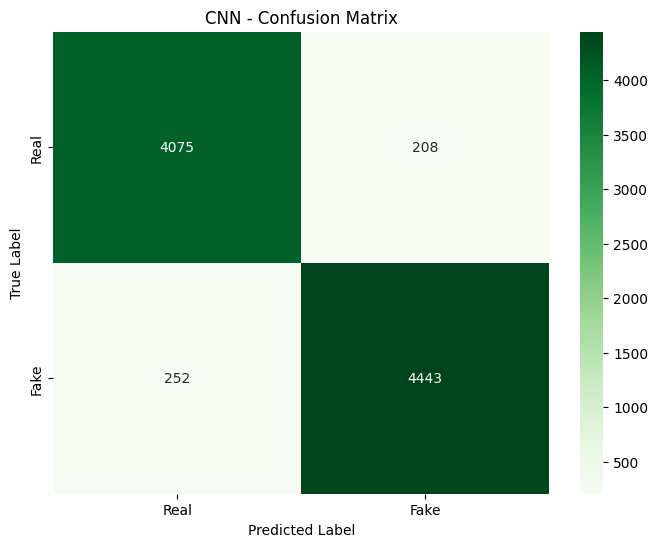


CNN Results: {'test_loss': 0.13101933277427513, 'test_accuracy': 0.9487636444642459, 'test_f1': 0.9487739542537331, 'test_precision': 0.9488298914650232, 'test_recall': 0.9487636444642459}


In [14]:
cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))

print("\nEvaluating CNN model on test set:")
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    cnn_model, test_loader, criterion, device
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Real', 'Fake']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('CNN - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

cnn_results = {
    'test_loss': float(test_loss),
    'test_accuracy': float(test_acc),
    'test_f1': float(test_f1),
    'test_precision': float(precision_score(test_labels, test_preds, average='weighted')),
    'test_recall': float(recall_score(test_labels, test_preds, average='weighted'))
}

print(f"\nCNN Results: {cnn_results}")

